# 💎 Diamonds Data Set Analysis with Julia

## 1. Libraries & Set Up

In [2]:
using RDatasets
using DataFrames, CategoricalArrays
using FreqTables
using StatsBase, Statistics
using Plots, StatsPlots
using Random, Distributions, HypothesisTests, GLM
using MLJ: OneHotEncoder
#

In [3]:
include("functions.jl");

In [4]:
ENV["COLUMNS"] = 40;  # Set number of columns to display
ENV["LINES"] = 20;    # Set number of lines to display

In [5]:
# Check the available data sets
first(sort!(RDatasets.datasets(), [:Rows, :Columns], rev = true), 10)

10×5 DataFrame
 Row │ Package   Dataset     Title     ⋯
     │ String15  String31    String    ⋯
─────┼──────────────────────────────────
   1 │ gap       mhtdata     An exampl ⋯
   2 │ lme4      InstEval    Universit
   3 │ ggplot2   movies      Movie inf
   4 │ ggplot2   diamonds    Prices of
   5 │ mlmRev    Chem97      Scores on ⋯
   6 │ Ecdat     VietNamI    Medical E
   7 │ COUNT     rwm         rwm
   8 │ mlmRev    star        Student T
   9 │ gamair    bird        bird      ⋯
  10 │ Ecdat     BudgetFood  Budget Sh
                       3 columns omitted

## 2. Load data & initial data exploration

The diamonds dataset serves as a comprehensive collection of over 50,000 diamonds, capturing key attributes such as size, shape, and price. This rich dataset provides invaluable insights into the factors that contribute to the market value of diamonds, making it a widely-used resource for data analysis, visualization, and machine learning tasks.

#### Features Description
* **carat**: The weight of the diamond, measured in carats.

* **cut**: The quality of the cut, categorized as "Fair," "Good," "Very Good," "Premium," or "Ideal."

* **color**: Diamond color, from J (worst) to D (best).

* **clarity**: A measurement of how clear the diamond is, categorized as "I1," "SI2," "SI1," "VS2," "VS1," "VVS2," "VVS1," "IF."

* **depth**: The height of a diamond, measured from the culet to the table, divided by its average girdle diameter.

* **table**: The width of the diamond's table expressed as a percentage of its average diameter.

* **price**: The price of the diamond in US dollars.

* **x**: Length in mm (rounded to the nearest hundredth).

* **y**: Width in mm (rounded to the nearest hundredth).

* **z**: Depth in mm (rounded to the nearest hundredth).

**Note:** *The "table" of a diamond refers to the flat facet on the top surface of the diamond, which is parallel to the plane of the girdle (the widest perimeter of the diamond). It is one of the critical parts of the diamond that contributes to its brilliance and sparkle. The table is where light enters and exits the diamond, playing a significant role in the diamond's optical performance.*

In [6]:
# load diamonds dataset
df = dataset("ggplot2", "diamonds");

In [7]:
# check the first 5 rows
first(df, 5)

5×10 DataFrame
 Row │ Carat    Cut      Color  Clarit ⋯
     │ Float64  Cat…     Cat…   Cat…   ⋯
─────┼──────────────────────────────────
   1 │    0.23  Ideal    E      SI2    ⋯
   2 │    0.21  Premium  E      SI1
   3 │    0.23  Good     E      VS1
   4 │    0.29  Premium  I      VS2
   5 │    0.31  Good     J      SI2    ⋯
                       7 columns omitted

In [8]:
# what is the shape of the data set?
size(df)

(53940, 10)

In [9]:
# size of our data set without duplicates
size(unique(df))

(53794, 10)

In [10]:
# How many duplicated rows do we have?
df_duplicates = df[nonunique(df), :];
size(df_duplicates)[1]

146

In [11]:
# check 10 random duplicated rows
df_duplicates[sample(1:size(df_duplicates, 1), 10, replace=false), :]

10×10 DataFrame
 Row │ Carat    Cut      Color  Clarit ⋯
     │ Float64  Cat…     Cat…   Cat…   ⋯
─────┼──────────────────────────────────
   1 │    0.33  Ideal    E      SI1    ⋯
   2 │    0.41  Premium  G      VS2
   3 │    0.32  Ideal    D      VVS1
   4 │    0.57  Premium  E      SI2
   5 │    2.01  Fair     H      SI2    ⋯
   6 │    0.52  Premium  G      SI2
   7 │    0.4   Ideal    J      VVS2
   8 │    0.33  Ideal    E      SI1
   9 │    0.5   Premium  D      SI2    ⋯
  10 │    0.31  Ideal    H      IF
                       7 columns omitted

In [12]:
# Remove duplicate rows
unique!(df);

In [13]:
size(df[nonunique(df), :])

(0, 10)

In [14]:
# check key statistics, data types, and missing values
describe(df)

10×7 DataFrame
 Row │ variable  mean     min   median ⋯
     │ Symbol    Union…   Any   Union… ⋯
─────┼──────────────────────────────────
   1 │ Carat     0.79778  0.2   0.7    ⋯
   2 │ Cut                Fair        
   3 │ Color              D           
   4 │ Clarity            I1          
   5 │ Depth     61.7481  43.0  61.8   ⋯
   6 │ Table     57.4581  43.0  57.0
   7 │ Price     3933.07  326   2401.0
   8 │ X         5.73121  0.0   5.7
   9 │ Y         5.73465  0.0   5.71   ⋯
  10 │ Z         3.53871  0.0   3.53
                       3 columns omitted

In [15]:
# check cardinality of our categorical values
values_Cut = unique(df[:, :Cut]);
values_Color = unique(df[:, :Color]);
values_Clarity = unique(df[:, :Clarity]);

In [16]:
println("Cut Categories: ", values_Cut)
println("Color Categories: ", values_Color)
println("Clarity Categories: ", values_Clarity)

Cut Categories: ["Ideal", "Premium", "Good", "Very Good", "Fair"]
Color Categories: ["E", "I", "J", "H", "F", "G", "D"]
Clarity Categories: ["SI2", "SI1", "VS1", "VS2", "VVS2", "VVS1", "I1", "IF"]


Clarity categories explanation:
* **SI2 (Slightly Included 2)**: Inclusions and/or blemishes are noticeable and can be seen with the naked eye.

* **SI1 (Slightly Included 1)**: Inclusions are noticeable under 10x magnification but usually invisible to the naked eye.

* **VS2 (Very Slightly Included 2)**: Minor inclusions that are somewhat easy to see under 10x magnification.

* **VS1 (Very Slightly Included 1)**: Minor inclusions that are difficult to see and are typically invisible to the naked eye.

* **VVS2 (Very, Very Slightly Included 2)**: Inclusions are difficult to see, even under 10x magnification.

* **VVS1 (Very, Very Slightly Included 1)**: Inclusions are extremely difficult to see under 10x magnification.

* **I1 (Included 1)**: Inclusions and/or blemishes are obvious and clearly visible without magnification.

* **IF (Internally Flawless)**: No inclusions and only blemishes are visible under 10x magnification.

Each category represents a range of how clear the diamond is of inclusions and blemishes, with "IF" being the best and "I1" being the most included.

Color categories explanation:
* **D**: Absolutely colorless, the highest grade, extremely rare.

* **E**: Also colorless, only minute traces of color can be detected by an expert gemologist.

* **F**: Considered colorless, slight color detected by an expert gemologist, but still a high-quality diamond.

* **G**: Near colorless, suitable for both white and colored metal settings, very common and great value.

* **H**: Near colorless, noticeable color when compared to diamonds of better grades, but still a good value.

* **I**: Near colorless with a slight warmth or tone, usually detectable even to the untrained eye.

* **J**: Noticeable color or tone, often yellow or brown, more affordable compared to higher grades.

Each letter grade represents a range of color in the diamond, with "D" being the most colorless and desirable, and "J" having noticeable color.

In [17]:
cut_order = ["Fair", "Good", "Very Good", "Premium", "Ideal"];
color_order = ["J", "I", "H", "G", "F", "E", "D"];
clarity_order = ["I1", "SI2", "SI1", "VS2", "VS1", "VVS2", "VVS1", "IF"];

In [18]:
# Memory usage
println("Memory usage MB: " * string(floor(Base.summarysize(df) / 1048576.0), 2))

Memory usage MB: 2.02


## 3. EDA

### 3.1. Univariate Analysis

#### Categorical features

In [19]:
columns_to_plot = [:Cut, :Color, :Clarity];

In [20]:
plots = []
for col in columns_to_plot
    push!(plots, plot_categorical_distribution(df, col))
end

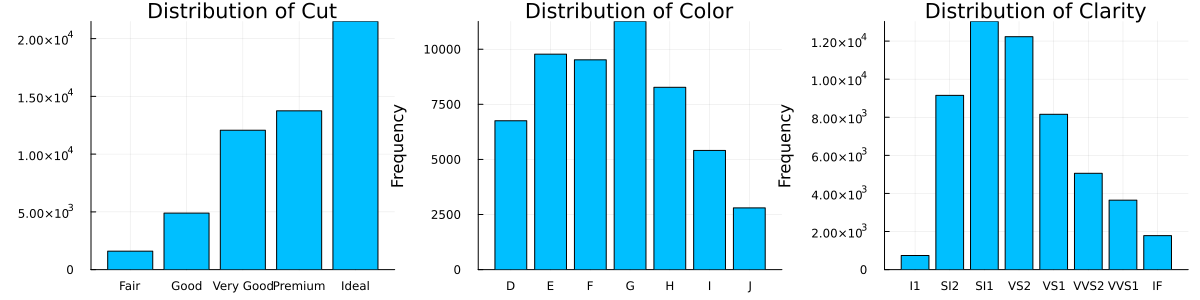

In [21]:
plot(plots..., layout=(1, 3), size=(1200, 300))

#### Summary:
* **Cut**: Majority in 'Ideal' category, followed by 'Premium' and 'Very Good'. 'Fair' cuts are least common.

* **Color**: Balanced distribution with fewer diamonds in 'D' and 'J'. Most common are 'G' and 'E' colors.

* **Clarity**: Significant numbers in 'SI1' and 'VS2' categories. 'I1' clarity diamonds are the rarest.

* **Overall**: Dataset mainly consists of diamonds with higher-quality characteristics.

#### Numerical features

#### -- Carat --

In [22]:
describe(select(df, "Carat"))[!, [1,2,3,4,5]]

1×5 DataFrame
 Row │ variable  mean     min      med ⋯
     │ Symbol    Float64  Float64  Flo ⋯
─────┼──────────────────────────────────
   1 │ Carat     0.79778      0.2      ⋯
                       2 columns omitted

Summary:
* **Mean**: Approximately 0.798 carats. This suggests that the average diamond size in the dataset is just below 0.8 carats.
* **Minimum**: The smallest diamond in the dataset is 0.2 carats, indicating a range of sizes including some quite small specimens.
* **Median**: The median size is 0.7 carats, which is slightly below the mean. This indicates that more than half of the diamonds are below the average size.
* **Maximum**: The largest diamond is exceptionally large at 5.01 carats, much larger than the average or median, suggesting the presence of some outliers in the dataset.

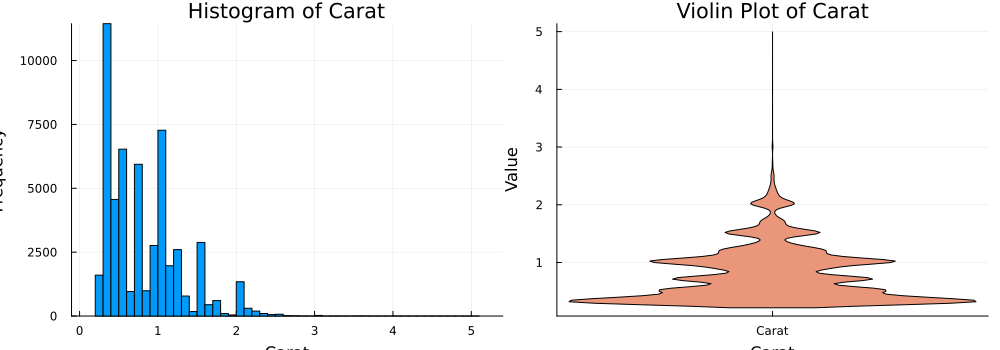

In [23]:
plot_histogram_violin(df, :Carat, bins=80)

In [24]:
percentile_analysis(df, :Carat)

6×2 DataFrame
 Row │ Percentile  Value   
     │ Float64     Float64 
─────┼─────────────────────
   1 │       0.25     0.4
   2 │       0.5      0.7
   3 │       0.75     1.04
   4 │       0.9      1.51
   5 │       0.95     1.7
   6 │       0.99     2.18

Summary:
* **25th percentile (0.25 => 0.4)**: 25% of the diamonds have a carat weight less than or equal to 0.4. These could be considered relatively small diamonds.

* **50th percentile (0.5 => 0.7)**: The median carat weight is 0.7, which means that 50% of diamonds are below this carat weight and 50% are above it. This gives us a good idea of what a 'typical' diamond might be like in terms of carat weight in this dataset.

* **75th percentile (0.75 => 1.04)**: 75% of diamonds have a carat weight less than or equal to 1.04. Diamonds above this carat weight could be considered relatively large within this dataset.

* **90th percentile (0.9 => 1.51)**: 90% of diamonds are below 1.51 carats, suggesting that diamonds larger than this are quite rare in the dataset.

* **95th percentile (0.95 => 1.7)**: 95% of diamonds have a carat weight less than or equal to 1.7, making diamonds larger than this extremely rare and likely very valuable.

* **99th percentile (0.99 => 2.18)**: Almost all diamonds (99%) have a carat weight less than 2.18. Diamonds larger than this are exceptionally rare in this dataset.

In [25]:
size(df)

(53794, 10)

Let's now examine how many stones havier than 2.18 carat (99th percentile) do we have in the data set.

In [26]:
df_large_stones = filter(row -> row[:Carat] > 2.18, df);
println(size(df_large_stones))
first(df_large_stones, 10)

(509, 10)


10×10 DataFrame
 Row │ Carat    Cut        Color  Clar ⋯
     │ Float64  Cat…       Cat…   Cat… ⋯
─────┼──────────────────────────────────
   1 │    2.22  Fair       J      I1   ⋯
   2 │    2.27  Fair       J      I1
   3 │    2.49  Fair       J      I1
   4 │    3.0   Very Good  H      I1
   5 │    2.21  Premium    H      I1   ⋯
   6 │    2.22  Fair       H      I1
   7 │    2.25  Fair       H      I1
   8 │    2.32  Fair       H      I1
   9 │    2.72  Fair       J      I1   ⋯
  10 │    2.23  Very Good  G      I1
                       7 columns omitted

There are 509 diamonds havier than 2.18 carat in our dataset. We can now see the carat distribution for these large stones.

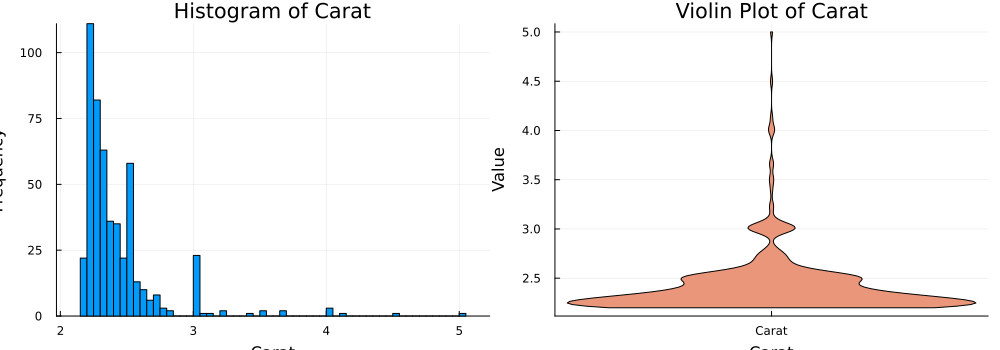

In [27]:
plot_histogram_violin(df_large_stones, :Carat, bins=80)

As observed, the majority of the larger stones have a weight ranging between 2.18 and 2.6 carats. There are a few exceptionally large diamonds, with weights of 4 carats and above. The largest stone in the dataset has a weight of 5.01 carats.

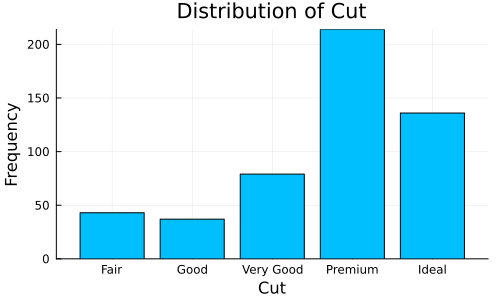

In [28]:
plot_categorical_distribution(df_large_stones, :Cut)

Interestingly, the distribution of cut quality shifts for larger stones. We observe that 'Premium' cut becomes the most frequent, unlike the overall trend where 'Ideal' cut is predominant. It's plausible that achieving an 'Ideal' cut is more challenging for larger diamonds compared to smaller ones.

#### -- Depth --

In [29]:
describe(select(df, "Depth"))[!, [1,2,3,4,5]]

1×5 DataFrame
 Row │ variable  mean     min      med ⋯
     │ Symbol    Float64  Float64  Flo ⋯
─────┼──────────────────────────────────
   1 │ Depth     61.7481     43.0      ⋯
                       2 columns omitted

Summary: 

* The average depth percentage across the dataset is approximately 61.93%
* The depth percentages range from a minimum of 56.1% to a maximum of 70.5%.
* The median depth percentage, representing the 50th percentile of the data, stands at 62.0%, indicating that half of the diamonds have a depth percentage below 62.0% and half have a depth percentage above 62.0%.
* The wide range in depth percentages reflects the variety of diamond proportions available in the dataset.

Note: The **Depth** variable in the dataset represents the ratio of the height of a diamond from the culet to the table, divided by its average girdle diameter, expressed as a percentage.

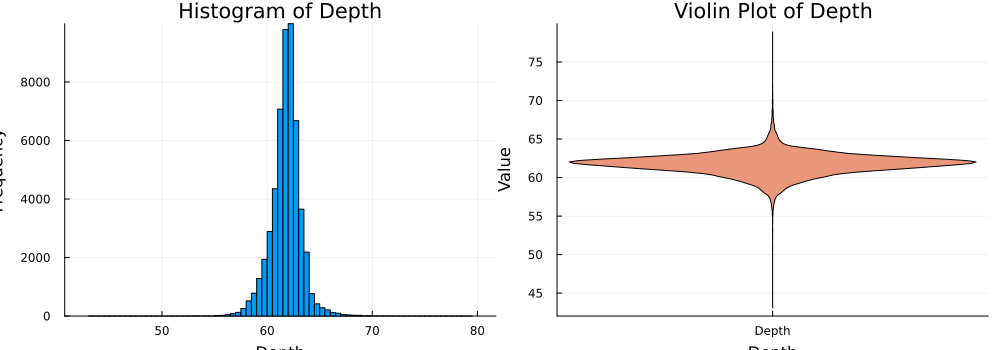

In [30]:
plot_histogram_violin(df, :Depth, bins=80)

In [31]:
percentile_analysis(df, :Depth)

6×2 DataFrame
 Row │ Percentile  Value   
     │ Float64     Float64 
─────┼─────────────────────
   1 │       0.25     61.0
   2 │       0.5      61.8
   3 │       0.75     62.5
   4 │       0.9      63.3
   5 │       0.95     63.8
   6 │       0.99     65.6

The distribution of the Depth variable closely approximates a normal distribution, with a substantial portion of the diamonds showcasing Depth values tightly clustered around the median of 61.8%. This concentration suggests a common standard in diamond cutting practices aimed at achieving a particular depth percentage, which, in turn, may reflect on the diamond's overall quality and appearance.

In [32]:
## examine whether the distribution is normal using QQ-Plot
# create_qq_plot(df, :Depth)

#### -- Table --

In [33]:
describe(select(df, "Table"))[!, [1,2,3,4,5]]

1×5 DataFrame
 Row │ variable  mean     min      med ⋯
     │ Symbol    Float64  Float64  Flo ⋯
─────┼──────────────────────────────────
   1 │ Table     57.4581     43.0      ⋯
                       2 columns omitted

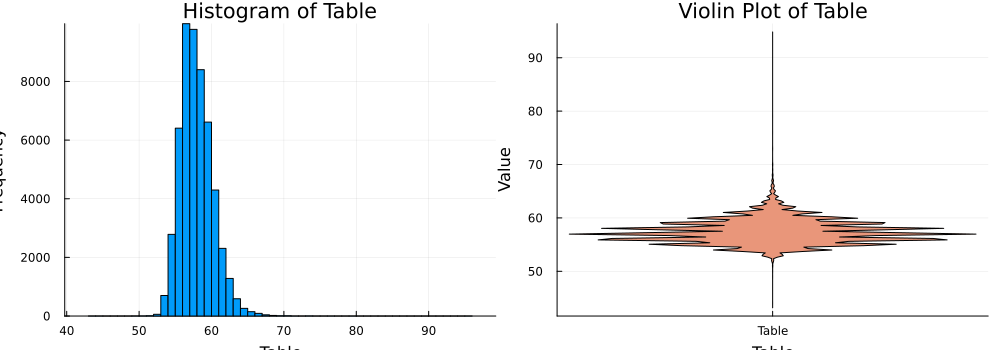

In [34]:
plot_histogram_violin(df, :Table, bins=80)

In [35]:
percentile_analysis(df, :Table)

6×2 DataFrame
 Row │ Percentile  Value   
     │ Float64     Float64 
─────┼─────────────────────
   1 │       0.25     56.0
   2 │       0.5      57.0
   3 │       0.75     59.0
   4 │       0.9      60.0
   5 │       0.95     61.0
   6 │       0.99     64.0

* The percentile analysis for the Table variable reveals a generally steady increase in value across the defined percentiles.
* At the 25th percentile, the Table value is 56.0, indicating that 25% of the diamonds have a Table size of 56.0 or less.
* The median (50th percentile) value is 57.0, which aligns closely with the mean value of 57.4581, suggesting a fairly symmetrical data distribution around the central value.
* The 75th percentile value is 59.0, showing that 75% of the diamonds have a Table size of 59.0 or smaller, while the remaining 25% have larger Table sizes.
* As we move towards the higher percentiles (90th, 95th, and 99th), the values are 60.0, 61.0, and 64.0 respectively. The increment between each adjacent pair of these high percentiles is consistent at 1.0, apart from the jump from 61.0 to 64.0 between the 95th and 99th percentiles. This final jump indicates a wider range in the Table sizes among the top 1% of the diamonds in the dataset.
* Overall, the percentile analysis portrays a gradual increase in the Table size, with a more pronounced increment at the upper extreme of the distribution, possibly hinting at the presence of outliers or a smaller subset of diamonds with notably larger Table sizes.

#### -- Price -- 

In [36]:
describe(select(df, "Price"))[!, [1,2,3,4,5]]

1×5 DataFrame
 Row │ variable  mean     min    media ⋯
     │ Symbol    Float64  Int32  Float ⋯
─────┼──────────────────────────────────
   1 │ Price     3933.07    326   2401 ⋯
                       2 columns omitted

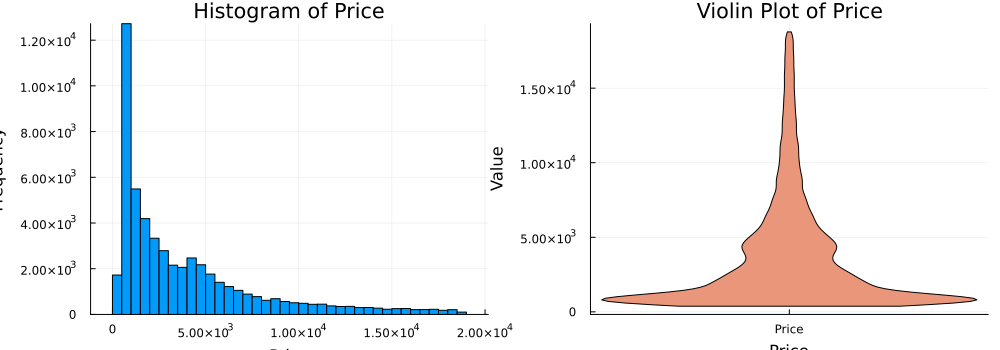

In [37]:
plot_histogram_violin(df, :Price, bins=80)

In [38]:
percentile_analysis(df, :Price)

6×2 DataFrame
 Row │ Percentile  Value    
     │ Float64     Float64  
─────┼──────────────────────
   1 │       0.25    951.0
   2 │       0.5    2401.0
   3 │       0.75   5326.75
   4 │       0.9    9818.7
   5 │       0.95  13100.0
   6 │       0.99  17377.1

* At the 25th percentile, the price is USD951, indicating that 25% of the diamonds are priced at USD951 or less.
* The median price (50th percentile) is significantly higher at USD2401, signifying that half of the diamonds are priced below this amount while the other half is priced higher.
* There is a substantial jump to the 75th percentile price of USD5326.75, showing a wider spread in prices among the more expensive diamonds.
* As we progress towards the higher percentiles (90th, 95th, and 99th), the prices increase drastically to USD9818.7, USD13100, and USD17377.1 respectively. This indicates a considerable spread in prices at the higher end of the distribution, reflecting a smaller subset of diamonds with significantly higher prices.
* The pronounced increment in prices across the higher percentiles suggests a right-skewed distribution, where a smaller number of diamonds have much higher prices compared to the rest.
* The wide range in prices, particularly from the median to the 99th percentile, underscores the diverse pricing structure of diamonds in this dataset, possibly due to varying qualities and characteristics.

#### -- X, Y, Z (Length, Width, Depth in mm) --

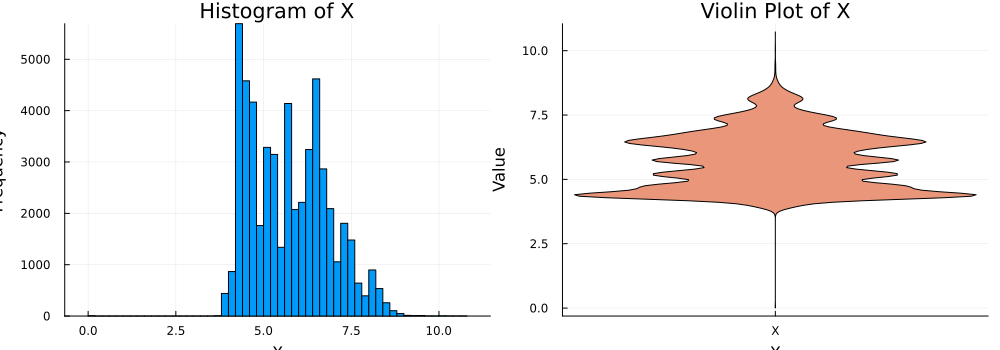

In [39]:
# length
plot_histogram_violin(df, :X, bins=80)

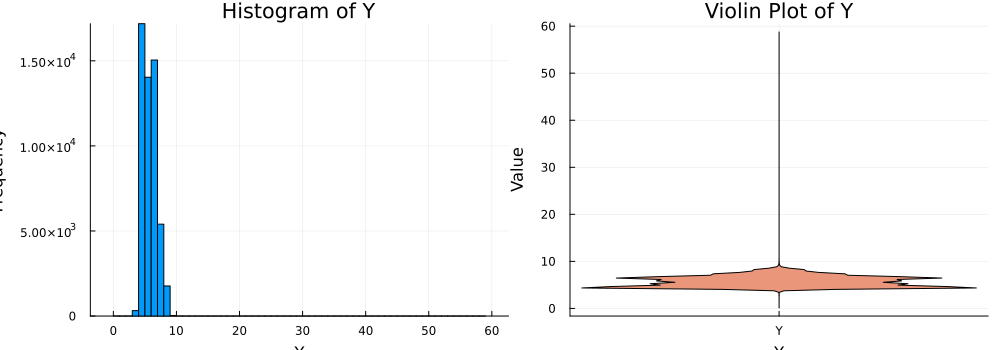

In [40]:
# width
plot_histogram_violin(df, :Y, bins=80)

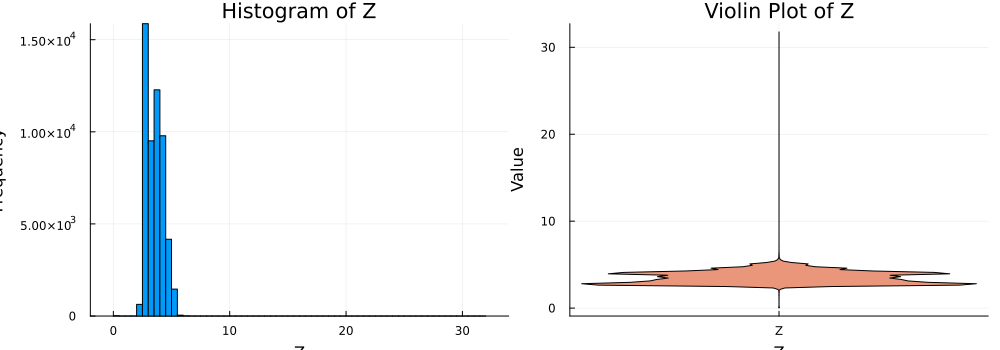

In [41]:
# depth
plot_histogram_violin(df, :Z, bins=80)

### 3.2. Multivariate Analysis

In [42]:
cor_df = compute_correlation_matrix(df)

7×8 DataFrame
 Row │ Feature  Carat      Depth       ⋯
     │ String   Float64    Float64     ⋯
─────┼──────────────────────────────────
   1 │ Carat    1.0         0.0278609  ⋯
   2 │ Depth    0.0278609   1.0
   3 │ Table    0.181091   -0.297669
   4 │ Price    0.921548   -0.0110475
   5 │ X        0.97538    -0.0253483  ⋯
   6 │ Y        0.951908   -0.0293891
   7 │ Z        0.953542    0.0947572
                       5 columns omitted

* **Strong Positive Correlations:**

Carat has a strong positive correlation with Price (0.92), X (0.98), Y (0.95), and Z (0.95) dimensions indicating that as the carat weight increases, the price and dimensions of the diamond increase as well.
* **Carat & Dimensions:**

Carat and the dimensions (X, Y, and Z) are highly correlated with each other, showcasing the inherent relationship between the weight and size of diamonds.
* **Price Correlations:**

Price also shares a strong positive correlation with the dimensions (X, Y, and Z) — around 0.86 to 0.88, implying that larger diamonds are priced higher.
* **Negative Correlation between Depth and Table:**

There's a moderate negative correlation (-0.30) between Depth and Table, suggesting that a larger table size is associated with a shallower depth.
* **Depth:**

Depth shows a very low correlation with all other features, making it relatively independent in terms of linear association.
* **Table & Dimensions:**

Table has a low to moderate positive correlation with the dimensions (X, Y, and Z) - around 0.15 to 0.19, indicating a mild linear relationship between table size and dimensions of the diamond.

┌ Warning: Keyword argument `orientation` is deprecated.
│ Please use `permute` instead.
└ @ Plots C:\Users\artem.kel\.julia\packages\Plots\sxUvK\src\args.jl:1552


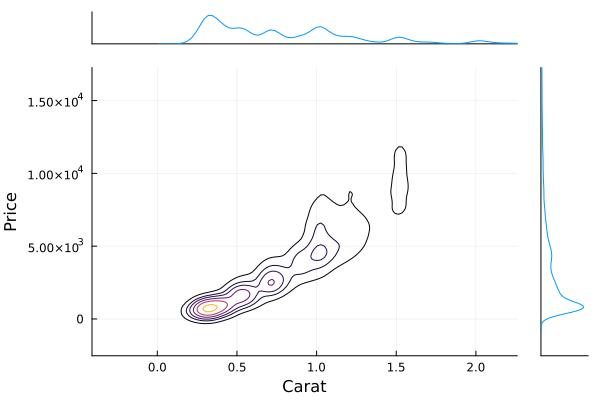

In [43]:
# examine the relationship btw Price & Carat 
x = df[:, :Carat]
y = df[:, :Price]

p = marginalkde(x, y; levels=7, clip=((-3, 3), (-3, 3)), 
#                 title="Marginal KDE of Price vs Carat",
                xlabel="Carat",
                ylabel="Price")  # You can adjust levels and clip as needed

display(p)

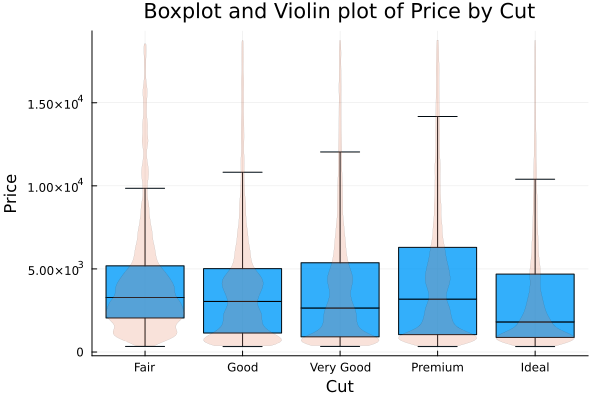

In [44]:
create_violin_boxplot(df, :Price, :Cut)

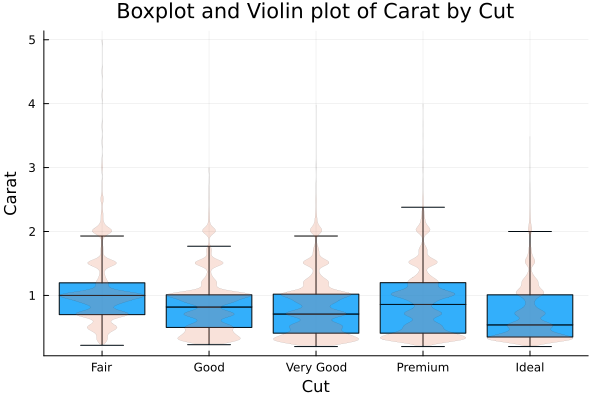

In [45]:
create_violin_boxplot(df, :Carat, :Cut)

In [46]:
aggregate_medians(df, :Cut)

5×3 DataFrame
 Row │ Cut        MedianPrice  MedianC ⋯
     │ Cat…       Float64      Float64 ⋯
─────┼──────────────────────────────────
   1 │ Fair            3282.0          ⋯
   2 │ Good            3042.0
   3 │ Very Good       2647.0
   4 │ Premium         3182.0
   5 │ Ideal           1813.0          ⋯
                        1 column omitted

* **Median Price**: The data reveals that the Fair cut commands the highest median price, closely followed by the Premium cut. Despite being the highest quality cut, the Ideal cut holds the lowest median price among the different cuts.

* **Median Carat**: It's clear from the data that the Fair cut diamonds have the highest median carat value, indicating they are on average, larger than diamonds of other cuts. On the other hand, Ideal cut diamonds have the lowest median carat value, suggesting they are, on average, smaller.

* **Price and Carat Relationship**: The strong positive correlation of 0.92 between carat and price showcases that larger diamonds (higher carat values) tend to be priced higher, overshadowing the premium associated with the quality of the cut. Despite the high quality of the Ideal cut, its lower median carat value corresponds with a lower median price.

* **Ideal Cut Rarity in Larger Diamonds**: It might be more challenging to achieve an Ideal cut as the diamond size increases, potentially due to the increased complexity of cutting larger diamonds to perfection.

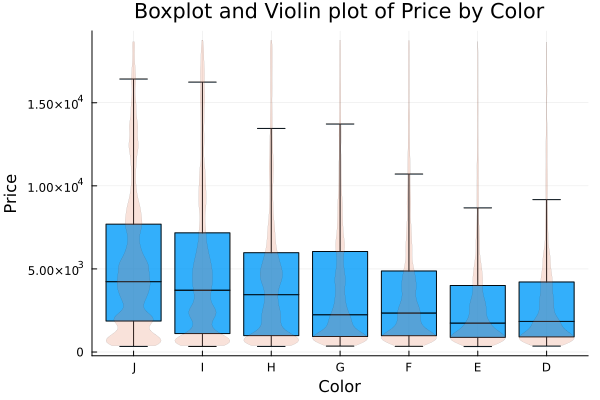

In [47]:
create_violin_boxplot(df, :Price, :Color)

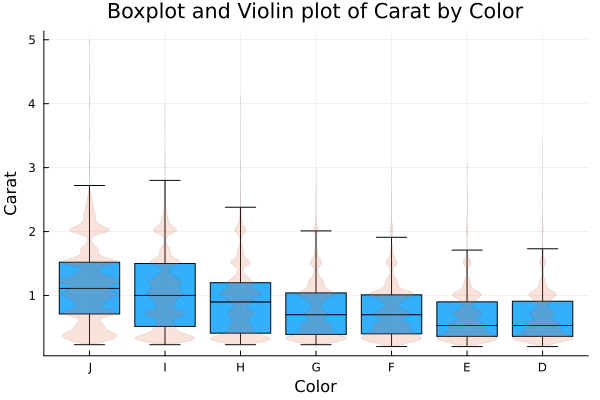

In [48]:
create_violin_boxplot(df, :Carat, :Color)

In [49]:
aggregate_medians(df, :Color)

7×3 DataFrame
 Row │ Color  MedianPrice  MedianCarat ⋯
     │ Cat…   Float64      Float64     ⋯
─────┼──────────────────────────────────
   1 │ D           1842.0         0.53 ⋯
   2 │ E           1741.5         0.53
   3 │ F           2345.0         0.7
   4 │ G           2246.0         0.7
   5 │ H           3452.5         0.9  ⋯
   6 │ I           3720.0         1.0
   7 │ J           4234.5         1.11

The data depicting the relationship between Color, Median Price, and Median Carat exhibits a similar phenomenon as seen with the Cut variable. Despite Color D being of the highest quality, it is associated with a lower median price, almost matching the next color grade E. Conversely, Color J, which is of lower quality, commands the highest median price. This can be primarily attributed to the median carat values, which increase as the color quality decreases. Larger diamonds (higher carat values) generally demand higher prices, overshadowing the influence of color quality on price. Hence, the lesser quality Color J diamonds have higher median carat values, leading to higher median prices. This analysis further emphasizes the substantial impact of carat weight on diamond pricing compared to other features such as cut and color.

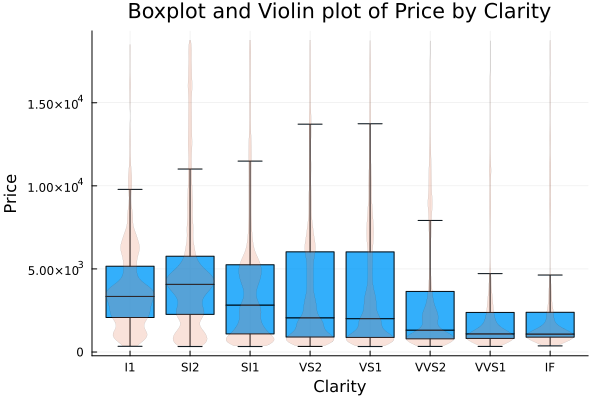

In [50]:
create_violin_boxplot(df, :Price, :Clarity)

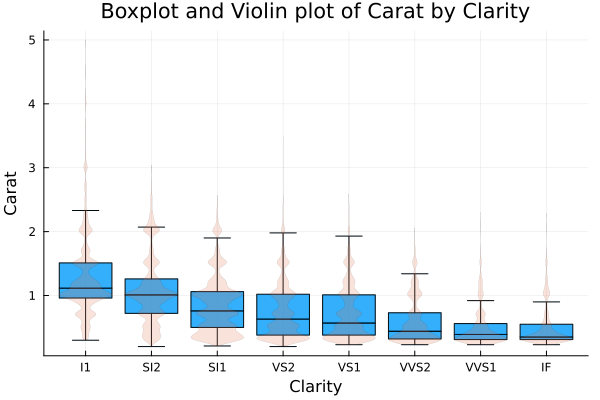

In [51]:
create_violin_boxplot(df, :Carat, :Clarity)

In [52]:
aggregate_medians(df, :Clarity)

8×3 DataFrame
 Row │ Clarity  MedianPrice  MedianCar ⋯
     │ Cat…     Float64      Float64   ⋯
─────┼──────────────────────────────────
   1 │ I1            3346.0        1.1 ⋯
   2 │ SI2           4071.5        1.0
   3 │ SI1           2822.0        0.7
   4 │ VS2           2061.0        0.6
   5 │ VS1           2010.0        0.5 ⋯
   6 │ VVS2          1316.0        0.4
   7 │ VVS1          1094.0        0.3
   8 │ IF            1080.0        0.3
                        1 column omitted

The table above illustrates a trend where diamonds with lower clarity grades have higher median prices due to their larger median carat weights. The highest clarity grade (IF) has the lowest median price due to its lowest median carat weight. Similarly, diamonds with a clarity grade of I1 and SI2, which are on the lower end of the clarity scale, have higher median prices driven by their larger carat weights. This trend reaffirms the strong influence of carat weight on diamond price across different clarity grades, overshadowing the impact of clarity on price.

Let's now investigate if the mean carat sizes differ significantly among the various clarity levels. For this, we will use the One-way analysis of variance (ANOVA) test.

In [53]:
# Split the Carat data by Clarity levels
groups = [df[df.Clarity .== clarity, :Carat] for clarity in unique(df.Clarity)]

# Apply OneWay ANOVA test
anova_result = OneWayANOVATest(groups...)

# Display the result
println(anova_result)

One-way analysis of variance (ANOVA) test
-----------------------------------------
Population details:
    parameter of interest:   Means
    value under h_0:         "all equal"
    point estimate:          NaN

Test summary:
    outcome with 95% confidence: reject h_0
    p-value:                     <1e-99

Details:
    number of observations: [9150, 13032, 8156, 12229, 5056, 3647, 740, 1784]
    F statistic:            1219.8
    degrees of freedom:     (7, 53786)



The **One-way ANOVA test** results strongly suggest that there are significant differences in the means of the **Carat** variable across the different **Clarity** levels. The extremely small p-value provides very strong evidence against the null hypothesis, leading us to reject it. In simpler terms, it's statistically unlikely that the observed differences in means occurred by random chance alone, and there's a genuine difference in diamond carat sizes across the clarity levels.

## 4. Modelling

### 4.1. Data prep

In [70]:
first(df, 5)

5×10 DataFrame
 Row │ Carat    Cut      Color  Clarit ⋯
     │ Float64  Cat…     Cat…   Cat…   ⋯
─────┼──────────────────────────────────
   1 │    0.23  Ideal    E      SI2    ⋯
   2 │    0.21  Premium  E      SI1
   3 │    0.23  Good     E      VS1
   4 │    0.29  Premium  I      VS2
   5 │    0.31  Good     J      SI2    ⋯
                       7 columns omitted

In [69]:
# one-hot-encodeing of categorical variables
df_encoded = one_hot_encode(df);
# examine new data frame
first(df_encoded, 5)

5×27 DataFrame
 Row │ Carat    Depth    Table    Pric ⋯
     │ Float64  Float64  Float64  Int3 ⋯
─────┼──────────────────────────────────
   1 │    0.23     61.5     55.0    32 ⋯
   2 │    0.21     59.8     61.0    32
   3 │    0.23     56.9     65.0    32
   4 │    0.29     62.4     58.0    33
   5 │    0.31     63.3     58.0    33 ⋯
                      24 columns omitted

In [73]:
function normalize_features(df::DataFrame)
    # Identify numerical columns
    numerical_cols = [colname for colname in names(df) if eltype(df[!, colname]) <: Real]

    for col in numerical_cols
        mean_val = mean(skipmissing(df[!, col]))
        std_val = std(skipmissing(df[!, col]))

        # Normalize the column
        df[!, col] = (df[!, col] .- mean_val) ./ std_val
    end
    return df
end

normalize_features (generic function with 1 method)

In [76]:
df_normalized = normalize_features(df_encoded);

In [77]:
describe(df_normalized)

27×7 DataFrame
 Row │ variable      mean          min ⋯
     │ Symbol        Float64       Flo ⋯
─────┼──────────────────────────────────
   1 │ Carat         -2.61044e-14   -1 ⋯
   2 │ Depth         -1.30184e-15  -13
   3 │ Table         -1.78707e-14   -6
   4 │ Price         -3.11089e-15   -0
   5 │ X              2.48195e-14   -5 ⋯
   6 │ Y             -5.00447e-15   -5
  ⋮  │      ⋮             ⋮            ⋱
  23 │ Clarity_VS2    6.01466e-15   -0
  24 │ Clarity_VVS2   4.31382e-14   -0
  25 │ Clarity_VVS1  -2.47772e-14   -0 ⋯
  26 │ Clarity_I1     2.33866e-14   -0
  27 │ Clarity_IF     3.89706e-14   -0
           5 columns and 16 rows omitted